In [5]:
# From:
# https://gist.github.com/eljost/2c4e1af652ef02b2989da341c5569af7
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
import scipy.stats as st

from sklearn import preprocessing


## Generic Gaussian process example

In [2]:
np.random.seed(1)

# Quadratic 2d potential
def func(x):
    return np.sum(x**2, axis=-1)


# Grid
lim = 1
res = 50
lin = np.linspace(-lim, lim, res)

# x1.shape = (50, 50)
x1, x2 = np.meshgrid(lin, lin)
# xx.shape = (2500, 2)
xx = np.vstack((x1.flatten(), x2.flatten())).T

# Analytic function values
y_analytic = func(xx)
y_analytic = y_analytic.reshape(-1, res)

# Observed data
obs = 15
# X.shape = (15, 2)
X = np.stack(
        (np.random.choice(lin, obs), np.random.choice(lin, obs)),
        axis=-1
)
y_obs = func(X)

kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=10)
gp.fit(X, y_obs)
print("Learned kernel", gp.kernel_)
# y_mean.shape = (2500, )
# y_cov.shape = (2500, 2500)
y_mean, y_cov = gp.predict(xx, return_cov=True)

posterior_nums = 3
posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov,
                                        size=posterior_nums)

Learned kernel RBF(length_scale=0.86)


In [3]:
xx.shape

(2500, 2)

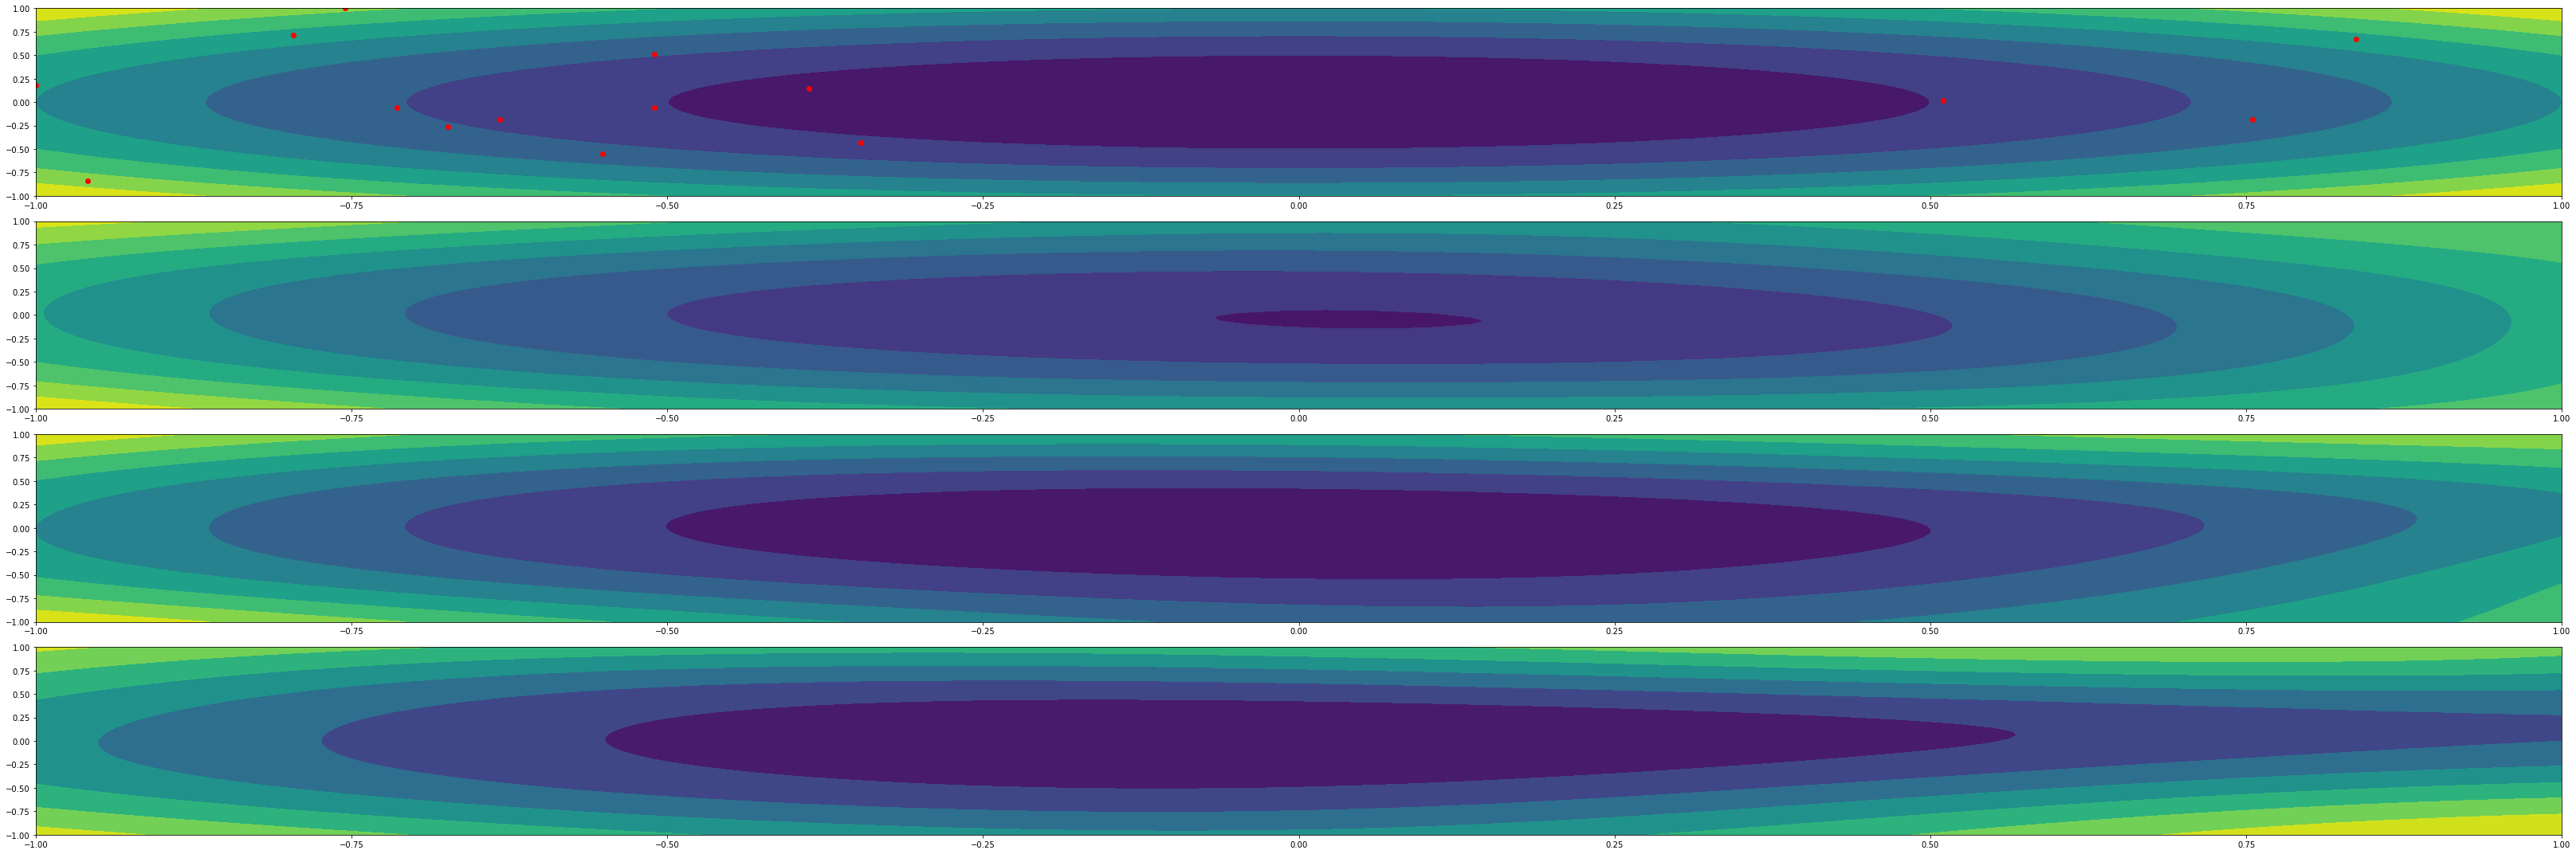

In [2]:

fig, axs = plt.subplots(posterior_nums+1, figsize=(45,15))

ax = axs[0]
ax.contourf(x1, x2, y_analytic)
ax.plot(X[:, 0], X[:, 1], "r.", ms=12)

for i, post in enumerate(posteriors, 1):
    axs[i].contourf(x1, x2, post.reshape(-1, res))

plt.tight_layout()
plt.show()

## Now, with feature-matching vectors

In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_affine import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

### Get the feature matches

In [84]:
opt = {'start_frame':0,
       'num_frames':3,
       'num_reference_frames':2,
       'start_slice':4,
       'add_affine_to_candidates':True,}
p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

out = track_via_reference_frames(btf_fname_red, **opt, preprocessing_settings=p)
all_matches, all_other_frames, reference_set = out


# Same opt for both
# opt = {'start_frame':0,
#        'num_frames':5,
#        'verbose':0,
#        'save_candidate_matches':True,
#        'add_affine_to_candidates':True,
#        'add_gp_to_candidates':True}
# p = PreprocessingSettings()
# p.do_filtering=False
# p.do_rigid_alignment=True
# p.do_mini_max_projection=True

# out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
# all_matches, all_conf, all_frames, candidates = out

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.88s/it]


### Build a vector field from this

In [85]:
pts0_unmatched = reference_set.reference_frames[0].keypoint_locs
pts1_unmatched = reference_set.reference_frames[1].keypoint_locs
feature_matches = reference_set.feature_matches[(0,1)]

n0_unmatched = reference_set.reference_frames[0].neuron_locs
n1_unmatched = reference_set.reference_frames[1].neuron_locs
all_matches = reference_set.pairwise_matches[(0,1)]

In [86]:
# Align the keypoints via matches
xyz = np.zeros((len(all_matches), 3), dtype=np.float32) # Start point
dat = np.zeros((len(all_matches), 3), dtype=np.float32) # Difference vector
f_xyz = np.zeros((len(feature_matches), 3), dtype=np.float32) # Start point
f_dat = np.zeros((len(feature_matches), 3), dtype=np.float32) # Difference vector

for m, f_match in enumerate(feature_matches):
    v0 = pts0_unmatched[f_match.queryIdx]
    v1 = pts1_unmatched[f_match.trainIdx]
    f_xyz[m, :] = v0
    f_dat[m, :] = v1 - v0
    
for m, match in enumerate(all_matches):
    v0 = n0_unmatched[match[0]]
    v1 = n1_unmatched[match[1]]
    xyz[m, :] = v0
    dat[m, :] = v1 - v0

<IPython.core.display.Javascript object>


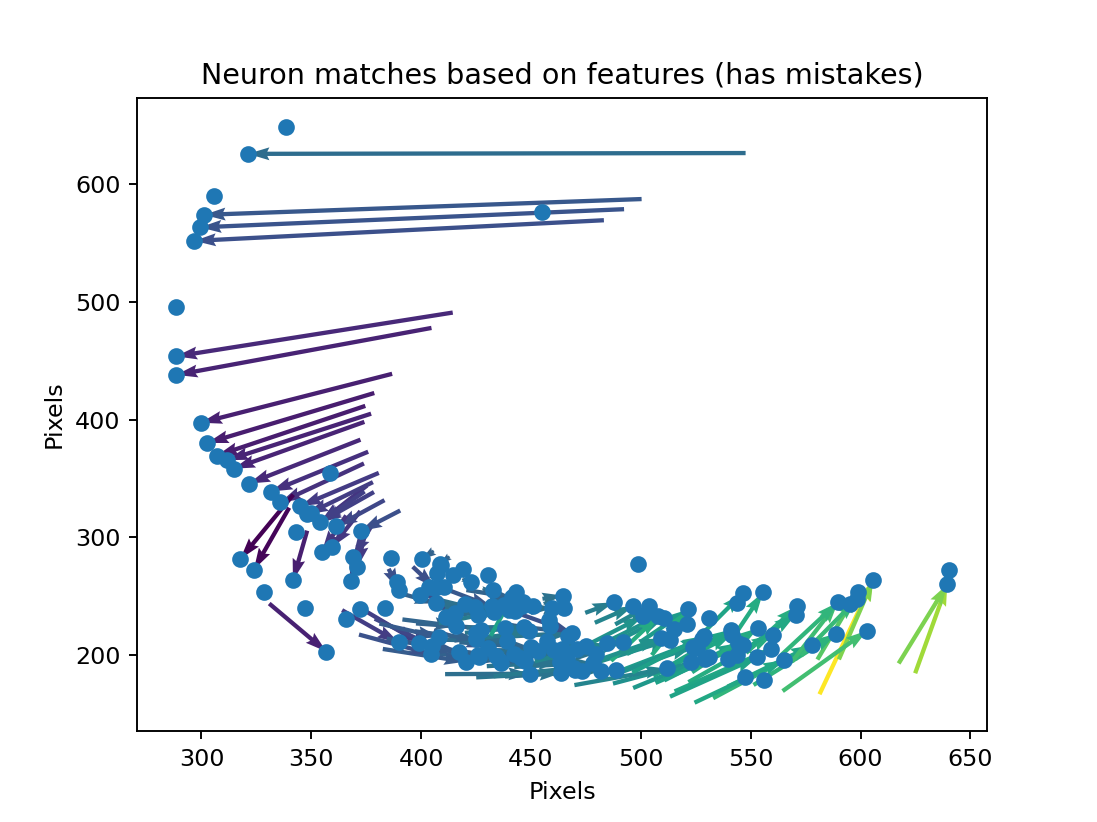

Text(0.5, 1.0, 'Neuron matches based on features (has mistakes)')

In [89]:
%matplotlib notebook

C = dat[:,2] / np.max(dat[:,1])
opt = {'angles':'xy', 'scale_units':'xy', 'scale':1}
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C, **opt)
plt.scatter(n1_unmatched[:,1], n1_unmatched[:,2])
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Neuron matches based on features (has mistakes)')

### Finally, GP

In [156]:

scaler = preprocessing.StandardScaler().fit(xyz)
xyz_scaled = scaler.transform(xyz)

In [176]:
# Do each coordinate independently

kernel = RBF(length_scale=2, length_scale_bounds=(1e-08, 10.0)) + \
    WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1))
opt = {'n_restarts_optimizer':10, 'alpha':0.0}
gpx = GaussianProcessRegressor(kernel=kernel,**opt)
gpx.fit(xyz_scaled[:,1:], dat[:,1])
gpy = GaussianProcessRegressor(kernel=kernel,**opt)
gpy.fit(xyz_scaled[:,1:], dat[:,2])
gpz = GaussianProcessRegressor(kernel=kernel,**opt)
gpz.fit(xyz_scaled[:,1:], dat[:,0])
print("Learned x kernel", gpx.kernel_)
print("Learned y kernel", gpy.kernel_)

x_predict, x_cov = gpx.predict(xyz_scaled[:,1:], return_cov=True)
y_predict, y_cov = gpy.predict(xyz_scaled[:,1:], return_cov=True)
z_predict, z_cov = gpz.predict(xyz_scaled[:,1:], return_cov=True)

# posterior_nums = 3
# posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov,
#                                         size=posterior_nums)

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Learned x kernel RBF(length_scale=2.08) + WhiteKernel(noise_level=1)
Learned y kernel RBF(length_scale=1.4) + WhiteKernel(noise_level=1)


<IPython.core.display.Javascript object>


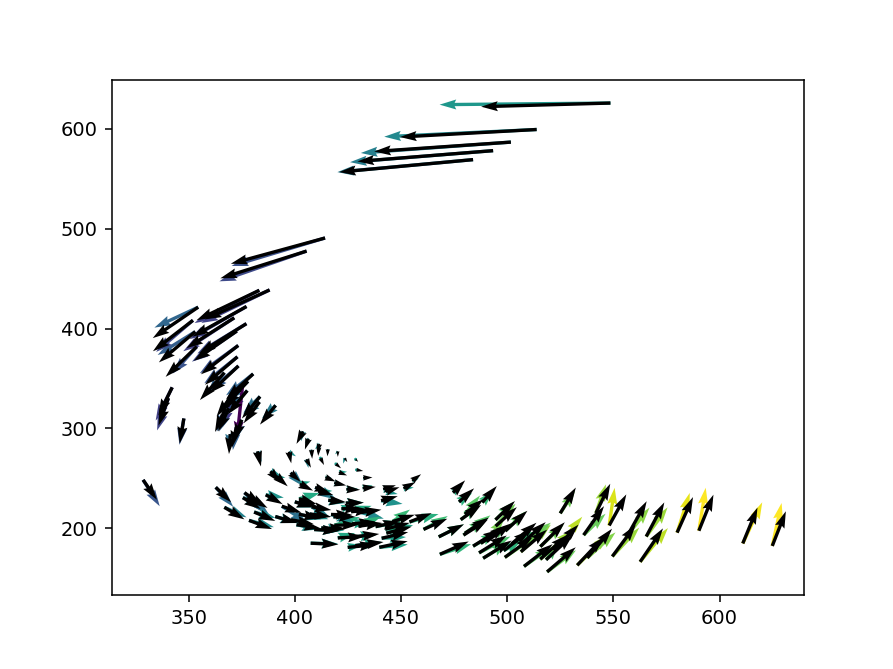

In [177]:
%matplotlib notebook

C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C)

# C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], x_predict, y_predict)

In [165]:
import open3d as o3d


In [179]:
# Original
pc0 = o3d.geometry.PointCloud()
pc0.points = o3d.utility.Vector3dVector(xyz)
pc0.paint_uniform_color([0,0,0])

# Where the points originally matched
pc1 = o3d.geometry.PointCloud()
pc1.points = o3d.utility.Vector3dVector(xyz + dat)
pc1.paint_uniform_color([0.5,0.5,0.5])

# line with the GP prediction
pc_gp = o3d.geometry.PointCloud()
dat_predict = np.transpose(np.vstack([z_predict, x_predict, y_predict]))
pc_gp.points = o3d.utility.Vector3dVector(xyz + dat_predict)
gp_lines = build_line_set_from_matches(pc0, pc_gp,
                                color=[0, 0, 1])


# o3d.visualization.draw_geometries([pc0, pc1, gp_lines])

In [181]:
f0, f1 = reference_set.reference_frames
to_draw = visualize_tracks(f0.neuron_locs, f1.neuron_locs, all_matches)
to_draw.append(gp_lines)

o3d.visualization.draw_geometries(to_draw)

### Try 2: train on feature matches, and predict on neurons

In [117]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(f_xyz)
f_xyz_scaled = scaler.transform(f_xyz)
xyz_scaled = scaler.transform(xyz)

ind = np.random.choice(f_xyz.shape[0], 500, replace=False)

In [154]:
# Do each coordinate independently

kernel = RBF(length_scale=0.5, length_scale_bounds=(1e-08, 10.0)) + \
    WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1))
opt = {'n_restarts_optimizer':10, 'alpha':1e-10}
gpx = GaussianProcessRegressor(kernel=kernel,**opt)
gpx.fit(f_xyz_scaled[ind,1:], f_dat[ind,1])
gpy = GaussianProcessRegressor(kernel=kernel,**opt)
gpy.fit(f_xyz_scaled[ind,1:], f_dat[ind,2])
print("Learned x kernel", gpx.kernel_)
print("Learned y kernel", gpy.kernel_)

x_predict, x_cov = gpx.predict(xyz_scaled[:,1:], return_cov=True)
y_predict, y_cov = gpy.predict(xyz_scaled[:,1:], return_cov=True)

# posterior_nums = 3
# posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov,
#                                         size=posterior_nums)

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Learned x kernel RBF(length_scale=1.76) + WhiteKernel(noise_level=1)
Learned y kernel RBF(length_scale=0.682) + WhiteKernel(noise_level=1)


<IPython.core.display.Javascript object>


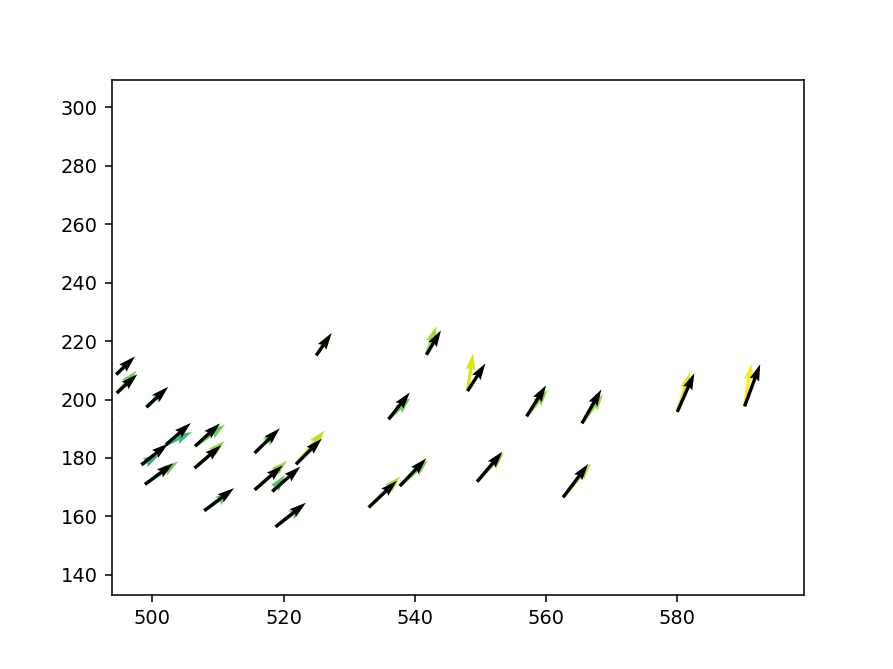

In [155]:
%matplotlib notebook

C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C)

# C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], x_predict, y_predict)

## Using non-isotropic basis function

In [109]:
k = (0,1)

# Syntax 1: if I did references frames
n0_unmatched = reference_set.reference_frames[0].neuron_locs
n1_unmatched = reference_set.reference_frames[1].neuron_locs
this_match = reference_set.pairwise_matches[(0,1)]
this_conf = reference_set.pairwise_conf[(0,1)]

# Syntax 2: if I did sequential matching
# n0_unmatched = all_frames[k[0]].neuron_locs
# n1_unmatched = all_frames[k[1]].neuron_locs
# this_match, this_conf = all_matches[k], all_conf[k]
# all_m, all_c, to_remove_ind = keep_best_match(this_match, this_conf)


# ALL points
xyz = np.zeros((len(this_match), 3), dtype=np.float32) # Start point
dat = np.zeros((len(this_match), 3), dtype=np.float32) # Difference vector
# dat_conf = np.zeros(len(this_match), dtype=np.float32) # Loosely, noise
for m, (match, conf) in enumerate(zip(this_match, this_conf)):
    v0 = n0_unmatched[match[0]]
    v1 = n1_unmatched[match[1]]
    xyz[m, :] = v0
    dat[m, :] = v1 - v0
#     dat_conf[m] = np.exp((1-conf)/1e-1)
# dat_conf /= 1e4*np.max(dat_conf)

In [110]:
len(all_matches)

141

In [111]:
scaler = preprocessing.StandardScaler().fit(xyz)
# f_xyz_scaled = scaler.transform(f_xyz)
xyz_scaled = scaler.transform(xyz)

scaler2 = preprocessing.StandardScaler().fit(dat)
dat_scaled = scaler2.transform(dat)
xyz_unmatched_scaled = scaler.transform(n0_unmatched)

# ind = np.random.choice(f_xyz.shape[0], 500, replace=False)

In [113]:
# Do each coordinate independently

# TEST some other kernels
from sklearn.gaussian_process.kernels import ConstantKernel

# Trivial result
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-08, 10.0))
# Trivial result again
kernel = ConstantKernel()*RBF(length_scale=0.5, length_scale_bounds=(1e-08, 10.0))
# Trivial result
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-08, 10.0))+ \
    WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1))

# kernel = DotProduct(sigma_0=0.1, sigma_0_bounds=(1e-4,100)) + \
#     RBF(length_scale=0.01, length_scale_bounds=(1e-08, 10.0)) #+ \
#     WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1))

opt = {'n_restarts_optimizer':10, 'alpha':1e-10}
# opt = {'n_restarts_optimizer':10, 'alpha':dat_conf}
gpx = GaussianProcessRegressor(kernel=kernel,**opt)
gpx.fit(xyz_scaled[:,1:], dat_scaled[:,1])
gpy = GaussianProcessRegressor(kernel=kernel,**opt)
gpy.fit(xyz_scaled[:,1:], dat_scaled[:,2])
gpz = GaussianProcessRegressor(kernel=kernel,**opt)
gpz.fit(xyz_scaled[:,1:], dat_scaled[:,0])
print("Learned x kernel", gpx.kernel_)
print("Learned y kernel", gpy.kernel_)
print("Learned z kernel", gpz.kernel_)

x_predict = gpx.predict(xyz_unmatched_scaled[:,1:])
y_predict = gpy.predict(xyz_unmatched_scaled[:,1:])
z_predict = gpz.predict(xyz_unmatched_scaled[:,1:])

tmp = scaler2.inverse_transform(np.vstack([z_predict,x_predict,y_predict]).T)
z_predict,x_predict,y_predict = tmp[:,0], tmp[:,1], tmp[:,2]

Learned x kernel RBF(length_scale=3.6) + WhiteKernel(noise_level=0.00906)
Learned y kernel RBF(length_scale=0.865) + WhiteKernel(noise_level=0.0396)
Learned z kernel RBF(length_scale=0.00144) + WhiteKernel(noise_level=2.34e-10)


In [114]:
dat.shape, np.vstack([z_predict,x_predict,y_predict]).T.shape

((141, 3), (148, 3))

<IPython.core.display.Javascript object>


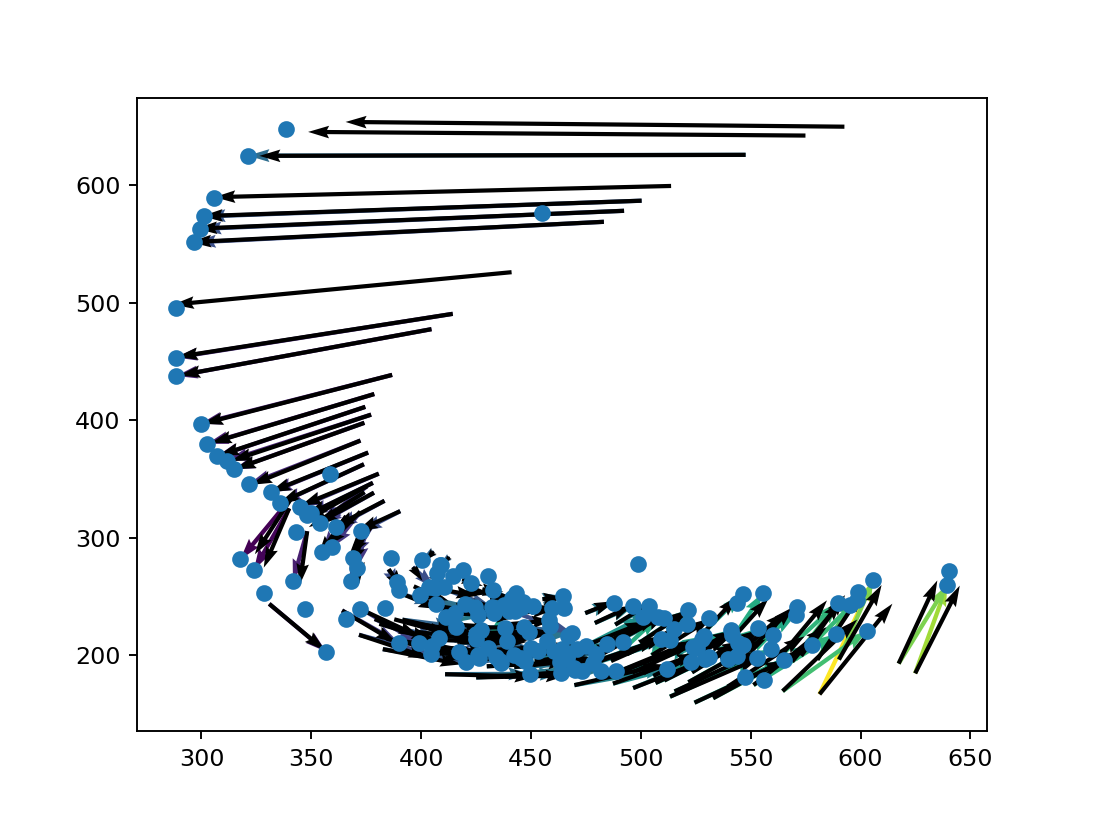

In [115]:
%matplotlib notebook
opt = {'angles':'xy', 'scale_units':'xy', 'scale':1}

C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C, **opt)

# C = dat[:,2] / np.max(dat[:,1])
plt.quiver(n0_unmatched[:,1], n0_unmatched[:,2], x_predict, y_predict, **opt)

# plt.scatter(n0_unmatched[:,1], n0_unmatched[:,2])
plt.scatter(n1_unmatched[:,1], n1_unmatched[:,2])

<IPython.core.display.Javascript object>


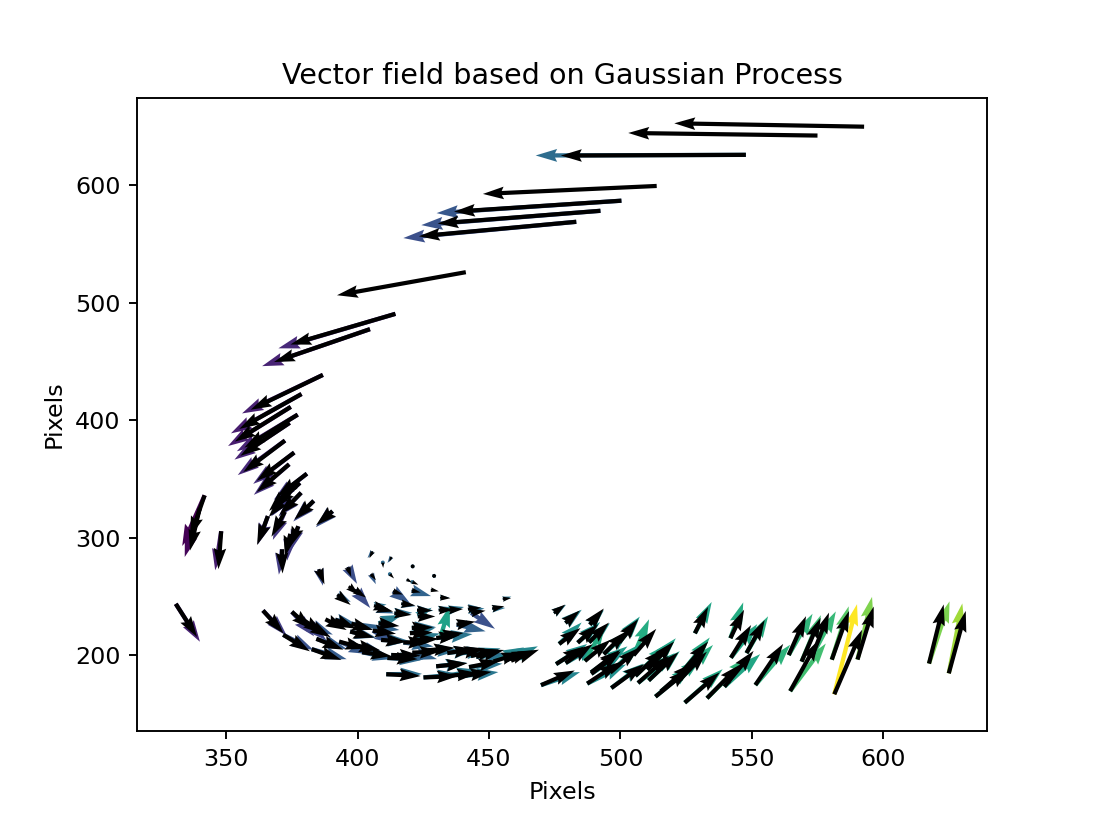

Text(0.5, 1.0, 'Vector field based on Gaussian Process')

In [117]:
%matplotlib notebook

C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C)
plt.quiver(n0_unmatched[:,1], n0_unmatched[:,2], x_predict, y_predict)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Vector field based on Gaussian Process')

In [46]:
## POINT CLOUD TIME

# Only keep the best points
all_m, all_c, to_remove_ind = keep_best_match(this_match, this_conf)
xyz2 = np.zeros((len(all_m), 3), dtype=np.float32) # Start point
dat2 = np.zeros((len(all_m), 3), dtype=np.float32) # Difference vector
# for m, match in enumerate(all_m):
for m, match in enumerate(this_match):
    v0 = n0_unmatched[match[0]]
    v1 = n1_unmatched[match[1]]
    xyz2[m, :] = v0
    dat2[m, :] = v1 - v0

# Use scaled versions of points
pc0 = build_neuron_tree(xyz2, False)[1]
pc0.paint_uniform_color([0,0,0])
pc1 = build_neuron_tree(xyz2+dat2, False)[1]
pc1.paint_uniform_color([0.5,0.5,0.5])

original_lines = build_line_set_from_matches(pc0, pc1, matches=None)

# Point cloud and lines for the pushed neurons
xyz_pushed = np.transpose(np.vstack([z_predict, x_predict, y_predict]))
# xyz_pushed = scaler.inverse_transform(xyz_pushed)
pc_pushed = build_neuron_tree(n0_unmatched+xyz_pushed, False)[1]

pc0_tmp = build_neuron_tree(n0_unmatched, False)[1]
new_lines = build_line_set_from_matches(pc0_tmp, pc_pushed, matches=None, color=[1,0,0])
new_lines.translate([0.5,0.5,0])

LineSet with 148 lines.

In [47]:
import open3d as o3d

pc0_all = build_neuron_tree(n0_unmatched, False)[1]
pc0_all.paint_uniform_color([0,0,0])
pc1_all = build_neuron_tree(n1_unmatched, False)[1]
pc1_all.paint_uniform_color([0.5,0.5,0.5])
o3d.visualization.draw_geometries([pc0_all, pc1_all, original_lines, new_lines])

## Another try: forward and backward matching

In [67]:
n0_unmatched = reference_set.reference_frames[0].neuron_locs
n1_unmatched = reference_set.reference_frames[1].neuron_locs
matches01 = reference_set.pairwise_matches[(0,1)]
matches10 = reference_set.pairwise_matches[(1,0)]

In [81]:
# ALL points
sz = len(matches01)+len(matches10)
xyz = np.zeros((sz, 3), dtype=np.float32) # Start point
dat = np.zeros((sz, 3), dtype=np.float32) # Difference vector
for i in range(sz):
    if i < len(matches01):
        match = matches01[i]
        v0 = n0_unmatched[match[0]].copy()
        v1 = n1_unmatched[match[1]].copy()
    else:
        matches = matches10[i-len(matches01)]
        v0 = n0_unmatched[match[1]].copy()
        v1 = n1_unmatched[match[0]].copy()
    xyz[i, :] = v0
    dat[i, :] = v1 - v0

scaler = preprocessing.StandardScaler().fit(xyz)
# f_xyz_scaled = scaler.transform(f_xyz)
xyz_scaled = scaler.transform(xyz)

scaler2 = preprocessing.StandardScaler().fit(dat)
dat_scaled = scaler2.transform(dat)
xyz_unmatched_scaled = scaler.transform(n0_unmatched)

# ind = np.random.choice(f_xyz.shape[0], 500, replace=False)

IndexError: index 158 is out of bounds for axis 0 with size 148

In [80]:
matches01

[[2, 41],
 [4, 24],
 [5, 12],
 [6, 19],
 [7, 13],
 [8, 133],
 [9, 66],
 [10, 17],
 [11, 18],
 [12, 21],
 [13, 56],
 [14, 14],
 [15, 25],
 [16, 20],
 [17, 14],
 [18, 34],
 [19, 22],
 [20, 26],
 [21, 81],
 [22, 59],
 [23, 29],
 [24, 55],
 [25, 30],
 [26, 23],
 [27, 37],
 [28, 48],
 [29, 38],
 [30, 26],
 [31, 46],
 [32, 54],
 [33, 50],
 [34, 36],
 [35, 25],
 [36, 70],
 [37, 53],
 [38, 57],
 [39, 72],
 [40, 39],
 [41, 31],
 [42, 41],
 [43, 61],
 [44, 62],
 [45, 90],
 [46, 49],
 [47, 76],
 [48, 42],
 [49, 64],
 [50, 60],
 [51, 65],
 [54, 47],
 [56, 67],
 [57, 91],
 [58, 66],
 [59, 35],
 [60, 45],
 [61, 51],
 [63, 33],
 [64, 68],
 [65, 26],
 [66, 27],
 [67, 100],
 [68, 80],
 [69, 83],
 [70, 95],
 [71, 77],
 [72, 86],
 [73, 74],
 [74, 28],
 [75, 73],
 [76, 96],
 [77, 82],
 [78, 58],
 [79, 125],
 [80, 89],
 [81, 93],
 [82, 85],
 [83, 99],
 [84, 92],
 [85, 79],
 [86, 97],
 [87, 106],
 [88, 136],
 [89, 94],
 [90, 87],
 [91, 74],
 [92, 104],
 [93, 107],
 [94, 98],
 [95, 108],
 [96, 81],
 [97, 103

In [76]:
# Do each coordinate independently

# TEST some other kernels
from sklearn.gaussian_process.kernels import ConstantKernel

# # Trivial result
# kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-08, 10.0))
# # Trivial result again
# kernel = ConstantKernel()*RBF(length_scale=0.5, length_scale_bounds=(1e-08, 10.0))
# Success
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-08, 10.0))+ \
    WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1))

# kernel = DotProduct(sigma_0=0.1, sigma_0_bounds=(1e-4,100)) + \
#     RBF(length_scale=0.01, length_scale_bounds=(1e-08, 10.0)) #+ \
#     WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1))

opt = {'n_restarts_optimizer':10, 'alpha':0.0}
# opt = {'n_restarts_optimizer':10, 'alpha':dat_conf}
gpx = GaussianProcessRegressor(kernel=kernel,**opt)
gpx.fit(xyz_scaled[:,1:], dat_scaled[:,1])
gpy = GaussianProcessRegressor(kernel=kernel,**opt)
gpy.fit(xyz_scaled[:,1:], dat_scaled[:,2])
gpz = GaussianProcessRegressor(kernel=kernel,**opt)
gpz.fit(xyz_scaled[:,1:], dat_scaled[:,0])
print("Learned x kernel", gpx.kernel_)
print("Learned y kernel", gpy.kernel_)
print("Learned z kernel", gpz.kernel_)

x_predict = gpx.predict(xyz_unmatched_scaled[:,1:])
y_predict = gpy.predict(xyz_unmatched_scaled[:,1:])
z_predict = gpz.predict(xyz_unmatched_scaled[:,1:])

tmp = scaler2.inverse_transform(np.vstack([z_predict,x_predict,y_predict]).T)
z_predict,x_predict,y_predict = tmp[:,0], tmp[:,1], tmp[:,2]

Learned x kernel RBF(length_scale=0.133) + WhiteKernel(noise_level=1e-10)
Learned y kernel RBF(length_scale=0.115) + WhiteKernel(noise_level=1e-10)
Learned z kernel RBF(length_scale=1e-08) + WhiteKernel(noise_level=1e-10)


# Full pipeline: matches from GP

1. Start with a set of matched neurons (e.g. generated from feature voting), with confidence for each match
2. Generate the vector field (i.e. fit 3 GPs, one for x,y,z)
3. Push the neurons along this vector field (even if there was no original match)
4. Do ICP to get a final match

In [118]:
k = (0,1)
n0_unmatched = all_frames[k[0]].neuron_locs.copy()
n1_unmatched = all_frames[k[1]].neuron_locs.copy()
this_match, this_conf = all_matches[k], all_conf[k]

# Increase z distances
n0_unmatched[:,0] *= 3
n1_unmatched[:,0] *= 3

matches, conf, pc_pushed, pc_target = calc_matches_using_gaussian_process(n0_unmatched, n1_unmatched, this_match, this_conf)

In [119]:

pc_original = build_neuron_tree(n0_unmatched, False)[1]
visualize_tracks_simple(pc_original, pc_target, matches)

LineSet with 147 lines.

# Try to use full pipeline function

In [145]:

opt = {'start_frame':0,
       'num_frames':3,
       'verbose':0,
       'save_candidate_matches':True,
       'add_affine_to_candidates':True,
       'add_gp_to_candidates':True}
p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
all_matches, all_conf, all_frames, candidates = out

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:48<00:00, 36.19s/it]


In [146]:
candidates

{(0, 1): [(2, 45, 0.5555555555555556),
  (2, 94, 0.1111111111111111),
  (2, 153, 0.2222222222222222),
  (4, 20, 0.02702702702702703),
  (4, 21, 0.5405405405405406),
  (4, 80, 0.21621621621621623),
  (4, 84, 0.02702702702702703),
  (4, 93, 0.02702702702702703),
  (4, 96, 0.08108108108108109),
  (4, 105, 0.02702702702702703),
  (4, 167, 0.02702702702702703),
  (5, 12, 0.07692307692307693),
  (5, 15, 0.3076923076923077),
  (5, 25, 0.15384615384615385),
  (5, 41, 0.07692307692307693),
  (5, 84, 0.07692307692307693),
  (5, 167, 0.23076923076923078),
  (6, 21, 0.037037037037037035),
  (6, 24, 0.7037037037037037),
  (6, 42, 0.07407407407407407),
  (6, 67, 0.037037037037037035),
  (6, 83, 0.07407407407407407),
  (6, 152, 0.037037037037037035),
  (7, 13, 0.16666666666666666),
  (7, 16, 0.16666666666666666),
  (7, 18, 0.3333333333333333),
  (7, 117, 0.16666666666666666),
  (8, 13, 0.3076923076923077),
  (8, 23, 0.23076923076923078),
  (8, 143, 0.38461538461538464),
  (9, 19, 0.6666666666666666),